<h1><center>Lab 2: Classification</center></h1>
<h3><center>A Deeper Analysis of Covid-19 Data</center></h3>
<p><center>DS 7331</center></p>
<p><center>Created by Sadik Aman, Dawn Bowerman, Zachary Harris, Alexandre Jasserme</center></p>

<p><center>Sections of this code was adapted from: 
    <li>https://github.com/jakemdrew/DataMiningNotebooks</li>
    <li> https://scikit-learn.org/stable/auto_examples/linear_model/plot_theilsen.html</li>
    <li> https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html </li>
    <li> https://machinelearningmastery.com/random-forest-ensemble-in-python/ </li>

## Data Preparation Part 1

> **Define and prepare your class variables. Use proper variable representations
(int, float, one-hot, etc.).
Use pre-processing methods (as needed) for dimensionality
reduction, scaling, etc. 
Remove variables that are not needed/useful for the analysis.**

In [1]:
from __future__ import print_function

#Libraries
import plotly
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
import time
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.pyplot import figure
from sklearn.model_selection import TimeSeriesSplit
import random as rd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn import metrics as mt
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import PredictionError

In [2]:
#Loading in the CSV file and displaying the resulting dataframe
covid_data = pd.read_csv('data/owid-covid-data.csv')
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154105 entries, 0 to 154104
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    154105 non-null  object 
 1   continent                                   144825 non-null  object 
 2   location                                    154105 non-null  object 
 3   date                                        154105 non-null  object 
 4   total_cases                                 151434 non-null  float64
 5   new_cases                                   151379 non-null  float64
 6   new_cases_smoothed                          150228 non-null  float64
 7   total_deaths                                134139 non-null  float64
 8   new_deaths                                  134314 non-null  float64
 9   new_deaths_smoothed                         134182 non-null  float64
 

In [3]:
# Prepare the variables

# Dropping attributes that are highly correlated or have many missing values (based on lab 1 analysis)
covid_df = covid_data.drop(covid_data.columns[[0,4,7,10,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,
                                                     27,28,29,30,31,32,
                                                     33,34,35,36,37,38,40,41,42,43,44,46,54,57,58,63,64,65,66]], axis=1)

# Removing dates before July 1st, 2021 and after December 31, 2021 to have a more manageable data set (with still more than 30,000 rows)
covid_df = covid_df[covid_df.date >= '2021-07-01']
covid_df = covid_df[covid_df.date <= '2021-12-31']

# Removing Oceania because it has a lot of missing values (based on lab 1 analysis)
covid_df = covid_df[~covid_df.continent.isin(['Oceania'])]

# Removing several countries with a lot of missing values (based on lab 1 analysis)
covid_df = covid_df[~covid_df.location.isin(['Turkmenistan', 'Northern Cyprus', 'Sint Maarten (Dutch part)', 'Jersey', 'Guernsey', 'Laos', 'Macao', 'Timor', 'Vatican', 'Saint Kitts and Nevis', 'Saint Vincent and the Grenadines', 'Saint Pierre and Miquelon', 'St. Helena', 'Cook Island', 'Greenland', 'Gibraltar', 'Anguilla'])]

# Handling missing values: our models cannot be trained on data set with missing data.
# We already removed columns and rows that have many missing data and we will impute the remaining missing data.
# Since we are dealing with data collected over time, we have to account for the temporal autocorrelation. 
# So, instead of using the column mean or median to fill-in the missing data, we chose to interpolate it.
covid_df = covid_df.interpolate()

# Creating a new category variable for stringency index that can be used for categorization
covid_df['stringency_range'] = pd.cut(covid_df.stringency_index,[0,10,20,30,40,50,60,70,80,90,100],10,labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']) # creating a new variable

# Creating a new category variable for new_cases that can be used for categorization
covid_df['new_cases_range'] = pd.qcut(covid_df.new_cases, 3, labels=["low", "medium", "high"])

# Creating a new category variable for new_deaths that can be used for categorization
covid_df['new_deaths_range'] = pd.qcut(covid_df.new_deaths, 3, labels=["low", "medium", "high"])

# Ideas from https://scikit-learn.org/stable/modules/cross_validation.html#timeseries-cv
# Sorting data frame by date column
covid_df['date'] = pd.to_datetime(covid_df['date']) # Converting data columnn to datetime
covid_df = covid_df.sort_values(by='date', ascending=True)

# Performing one hot encoding of the location variable - we will not use it in the final model, the explanation is in the next cell
categ_features = ['location'];
one_hot_df = pd.concat([pd.get_dummies(covid_df[col],prefix=col) for col in categ_features], axis=1)

# Dropping more attributes that are highly correlated or have many missing values (based on lab 1 analysis) or that will not be used for this analysis (stringency_range and new_deaths_range)
covid_df = covid_df.drop(["new_deaths_smoothed",
                    "new_cases",
                    "new_cases_smoothed",
                    "continent",
                    "location",
                    "stringency_range",
                    "date",
                    "new_people_vaccinated_smoothed",
                    "population_density",
                    "aged_70_older",
                    "new_deaths_range"], axis=1)

In [4]:
# We investigated one hot encoding of the location variable. 
# Unfortunately, this increase greatly the size of the model (it would have more than 200 rows) so we decided to not use the location variable in the final model
one_hot_df.head()

,location_Afghanistan,location_Africa,location_Albania,location_Algeria,location_Andorra,location_Angola,location_Antigua and Barbuda,location_Argentina,location_Armenia,location_Aruba,...,location_United States,location_Upper middle income,location_Uruguay,location_Uzbekistan,location_Venezuela,location_Vietnam,location_World,location_Yemen,location_Zambia,location_Zimbabwe
493,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
122783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 ## Data Preparation Part 2 

> **Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).**

In [5]:
print ('Size of the final dataset showing that is has more than 30,000 rows and 15 columns:', covid_df.shape)

Size of the final dataset showing that is has more than 30,000 rows and 15 columns: (37168, 15)


In [6]:
# Overview of the data set:
covid_df.info() #Dataset being analyzed (MAIN DATASET)
covid_df.head() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37168 entries, 493 to 154092
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   new_deaths                  37168 non-null  float64 
 1   reproduction_rate           37168 non-null  float64 
 2   new_vaccinations_smoothed   37168 non-null  float64 
 3   stringency_index            37168 non-null  float64 
 4   population                  37168 non-null  float64 
 5   median_age                  37168 non-null  float64 
 6   aged_65_older               37168 non-null  float64 
 7   gdp_per_capita              37168 non-null  float64 
 8   cardiovasc_death_rate       37168 non-null  float64 
 9   diabetes_prevalence         37168 non-null  float64 
 10  handwashing_facilities      37168 non-null  float64 
 11  hospital_beds_per_thousand  37168 non-null  float64 
 12  life_expectancy             37168 non-null  float64 
 13  human_develop

,new_deaths,reproduction_rate,new_vaccinations_smoothed,stringency_index,population,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,new_cases_range
493,91.0,0.98,14115.0,46.30,39835428.0,18.6,2.581,1803.987,597.029,9.59,37.746000,0.500,64.83,0.511,high
24994,0.0,0.35,2773.0,29.63,27224262.0,18.8,3.165,3364.926,244.661,7.20,2.735000,1.300,59.29,0.563,low
122783,0.0,0.88,11516.0,32.41,6871547.0,41.2,17.366,14048.881,439.415,10.08,97.719000,5.609,76.00,0.806,medium
24316,26.0,1.10,132856.0,72.69,16946446.0,25.6,4.412,3645.070,270.892,4.00,66.229000,0.800,69.82,0.594,high
123452,1.0,0.93,116.0,76.85,98910.0,36.2,8.606,26382.287,242.648,10.55,97.294978,3.600,73.40,0.796,medium


The original Covid dataset was obtained from the "Our World in Data" website: https://github.com/owid/covid-19-data/tree/master/public/data 

In "Data Preparation Step 1", we removed several attributes from the dataset and here is a description of the remaining attributes in the final dataset will be used for this analysis:
<p><center>Table 1: Attributes</center></p>

| Variable Name                  | Data Type | Description                                                                                                                                                                                                                                                                                                                                           |
|--------------------------------|-----------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| new_deaths                     | numerical | New deaths attributed to COVID-19                                                                                                                                                                                                                                                                                                                     |
| reproduction_rate              | numerical | Real-time estimate of the effective reproduction rate (R) of COVID-19                                                                                                                                                                                                                                                                                 |
| new_vaccinations_smoothed      | numerical | New COVID-19 vaccination doses administered (7-day smoothed).  For countries that don't report vaccination data on a daily basis,  we assume that vaccination changed equally on a daily basis over any periods in which  no data was reported. This produces a complete series of daily figures, which is  then averaged over a rolling 7-day window |
| stringency_index               | numerical | Government Response Stringency Index: composite measure based on 9 response  indicators including school closures, workplace closures,  and travel bans, rescaled to a value from 0 to 100 (100 = strictest response)                                                                                                                                 |
| population                     | numerical | Population                                                                                                                                                                                                                                                                                                                                            |
| median_age                     | numerical | Median age of the population, UN projection for 2020                                                                                                                                                                                                                                                                                                  |
| aged_65_older                  | numerical | Share of the population that is 65 years and older, most recent year available                                                                                                                                                                                                                                                                        |
| gdp_per_capita                 | numerical | Gross domestic product at purchasing power parity  (constant 2011 international dollars),  most recent year available                                                                                                                                                                                                                                 |
| cardiovasc_death_rate          | numerical | Death rate from cardiovascular disease in 2017 (annual number of deaths per 100,000 people)                                                                                                                                                                                                                                                           |
| diabetes_prevalence            | numerical | Diabetes prevalence (% of population aged 20 to 79) in 2017                                                                                                                                                                                                                                                                                           |
| handwashing_facilities         | numerical | Share of the population with basic handwashing facilities on premises,  most recent year available                                                                                                                                                                                                                                                    |
| hospital_beds_per_thousand     | numerical | Hospital beds per 1,000 people, most recent year available since 2010                                                                                                                                                                                                                                                                                 |
| life_expectancy                | numerical | Life expectancy at birth in 2019                                                                                                                                                                                                                                                                                                                      |
| human_development_index        | numerical | A composite index measuring average achievement in three basic  dimensions of human development—a long and healthy life,  knowledge and a decent standard of living.                                                                                                                                                                                  |
| new_cases_range                | categorical | This is a new variable that will be used to perform the classification task. It was created from the continuous variable new_deaths_range by dividing it in 3 equal parts with values: "high", "medium" and "low".                                                   
                                                                                                                                        |

#### Task 1: Classification of new_cases_range
Task 1 will consist of the classification of the categorical variable new_cases_range.

#### Task 2: Regression of new_deaths
Task 2 will consist of the regression of the continuous variable new_deaths.

 ## Modeling and Evaluation 1

> **Choose and explain your evaluation metrics that you will use (i.e., accuracy,precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.**

For our categorical models we chose *accuracy* to be our evaluation metric. Accuracy is a classification metric that measures the ratio of the amount of times the model correctly predicts the right answer divided by the total number of answers. Accuracy is a metric for categorical data where the answer is discrete. A model with a higher prediction accuracy is a better representation of the data.

We have selected the *Root Mean Squared Error (RMSE)* for our Regression evaluation metric. The RMSE measures the average error produced by the model while predicting the result for a study. The RMSE is the square root of the mean squared error (MSE); the average squared difference between the observed actual results and the results predicted by the model. The MSE = mean((observed - predicted)^2) and the RMSE = sqrt(MSE). A model with a lower RMSE is a better model. We believe that this metric is appropriate because RMSE is a mathematical equation that equates the error between the predicted and the actual results to determine the correctness of a model. Since our regression response data is numerical, it is a likely choice as metrics for binary data will not work here.

 ## Modeling and Evaluation 2 

> **Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.**

The data in our dataset was collected over time and we cannot use the traditional k-fold cross-validation techniques since we want to avoid the situation where we train a model using future information.  
So we are using TimeSeriesSplit from Scikit-Learn with a number of splits set to 10 in order to generate the training and test set (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [7]:
rd.seed(123) #Setting the seed to maintain consistency and reproducibility of results

#Create Train Test Split for Regression
cv_object = TimeSeriesSplit( n_splits=10)

reg_target = covid_df.new_deaths

#separate the other attributes from the predicting attribute and adjust dataset for regrssion
#reg_df is equivalent to the covid_df dataset, but with an eliminated categorical feature (new_cases_range)
reg_df = covid_df
reg_df = reg_df.drop(["new_deaths","new_cases_range"], axis=1)

X_reg = np.array(reg_df)
y_reg = np.array(reg_target)

for train_indices, test_indices in cv_object.split(X_reg,y_reg): 
    
    X_train_reg = X_reg[train_indices]
    y_train_reg = y_reg[train_indices]
    
    X_test_reg = X_reg[test_indices]
    y_test_reg = y_reg[test_indices]    
    
# scale attributes by the training set
scl_obj_reg = StandardScaler()
scl_obj_reg.fit(X_train_reg) # find scalings for each column that make this zero mean and unit std

X_train_scaled_reg = scl_obj_reg.transform(X_train_reg) # apply to training
X_test_scaled_reg = scl_obj_reg.transform(X_test_reg) # apply those means and std to the test set (without snooping at the test set values)

In [8]:
#Create Train Test Split for Classification
cv_object = TimeSeriesSplit( n_splits=10)

cat_target = covid_df.new_cases_range

#separate the other attributes from the predicting attribute
#Adjusting categorical dataframe to be used for classification models
#Eliminated our response variable, new_cases_range, and a highly correlated variable, new_deaths

cat_df = covid_df
cat_df = cat_df.drop(["new_cases_range","new_deaths"],axis=1)

X_cat = np.array(cat_df)
y_cat = np.array(cat_target)

for train_indices, test_indices in cv_object.split(X_cat,y_cat): 
    
    X_train_cat = X_cat[train_indices]
    y_train_cat = y_cat[train_indices]
    
    X_test_cat = X_cat[test_indices]
    y_test_cat = y_cat[test_indices]
    
# scale attributes by the training set
scl_obj_cat = StandardScaler()
scl_obj_cat.fit(X_train_cat) # find scalings for each column that make this zero mean and unit std

X_train_scaled_cat = scl_obj_cat.transform(X_train_cat) # apply to training
X_test_scaled_cat = scl_obj_cat.transform(X_test_cat) # apply those means and std to the test set (without snooping at the test set values)

 ## Modeling and Evaluation 3

> **Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!**

From the data preparation portion of this report, we recall that the tasks being addressed in this analysis are
the classification of new_cases_range and the regression of new_deaths. The models chosen for each each task are outlined below.

* Task 1: Classification of new_cases_range: Task 1 will consist of the classification of the categorical variable new_cases_range.

    * Support Vector Machines (SVMs)
    * Naive-Bayes
    * kNN

* Task 2: Regression of new_deaths: Task 2 will consist of the regression of the continuous variable new_deaths.
    * Linear Regression
    * Theil–Sen Regression
    * RANSAC Regression
    * Random Forest Regression
    
The models will be created in the following sections below.

### *Task 1: Classification of new_cases_range*

### Support Vector Machines

#### Creating the Model Using Support Vector Machines

In [9]:
%%time
# SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model
svm_clf = SVC(C=0.5, kernel='rbf', decision_function_shape='ovo', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled_cat, y_train_cat)  # train object

y_hat_cat = svm_clf.predict(X_test_scaled_cat) # get test set predictions

acc_cat = mt.accuracy_score(y_test_cat,y_hat_cat)
conf = mt.confusion_matrix(y_test_cat,y_hat_cat, labels = ["high","medium","low"])
print('accuracy:', acc_cat )
print(conf)
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

# make a dataframe of the training data
df_tested_on = cat_df.iloc[train_indices].copy() # saved from above, the indices chosen for training
# get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['new_deaths_range'] = y_cat[svm_clf.support_] # add back in the 'new_deaths_range' Column to the pandas dataframe
cat_df['new_deaths_range'] = y_cat # also add it back in for the original data
df_support.info()

# statistics of the attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['new_deaths_range'])
df_grouped = cat_df.groupby(['new_deaths_range'])

accuracy: 0.6391355831853167
[[796 286  87]
 [195 671 328]
 [ 90 233 692]]
(20836, 13)
(20836,)
[5531 6461 8844]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20836 entries, 493 to 131950
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   reproduction_rate           20836 non-null  float64
 1   new_vaccinations_smoothed   20836 non-null  float64
 2   stringency_index            20836 non-null  float64
 3   population                  20836 non-null  float64
 4   median_age                  20836 non-null  float64
 5   aged_65_older               20836 non-null  float64
 6   gdp_per_capita              20836 non-null  float64
 7   cardiovasc_death_rate       20836 non-null  float64
 8   diabetes_prevalence         20836 non-null  float64
 9   handwashing_facilities      20836 non-null  float64
 10  hospital_beds_per_thousand  20836 non-null  float64
 11  life_expectancy             2

In [10]:
from scipy.stats import t

# Let’s now simulate a dataset made of 100 numbers extracted from a normal distribution
x = np.random.normal(size=100)

# calculate the 95% confidence interval of the mean value.
m = x.mean()
s = x.std()

dof = len(x)-1

confidence = 0.95
t_crit = np.abs(t.ppf((1-confidence)/2,dof))

print('The median vlaue is',m) 
print('The standardizaion vlaue is ',s) 

# calculate the 95% confidence interval.
(m-s*t_crit/np.sqrt(len(x)), m+s*t_crit/np.sqrt(len(x)))

The median vlaue is 0.038665322401037046
The standardizaion vlaue is  1.0003282579969057


(-0.1598215062580241, 0.23715215106009818)

### Naive - Bayes

In [11]:
%%time
#### Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Trying with default parameter
gnb_clf = GaussianNB()
gnb_clf.fit(X_train_scaled_cat, y_train_cat)

y_hat_cat = gnb_clf.predict(X_test_scaled_cat) # get test set predictions

acc_cat = mt.accuracy_score(y_test_cat,y_hat_cat)
conf = mt.confusion_matrix(y_test_cat,y_hat_cat, labels = ["high","medium","low"])
print('accuracy:', acc_cat )

print('\n')

print('The confusion matrix is\n',conf)

accuracy: 0.4487862640615749


The confusion matrix is
 [[281 659 229]
 [ 47 624 523]
 [  9 395 611]]
CPU times: user 49.8 ms, sys: 4.58 ms, total: 54.4 ms
Wall time: 54.3 ms


In [12]:
from scipy.stats import t

# Let’s now simulate a dataset made of 100 numbers extracted from a normal distribution
x = np.random.normal(size=100)

# calculate the 95% confidence interval of the mean value.
m = x.mean()
s = x.std()

dof = len(x)-1

confidence = 0.95
t_crit = np.abs(t.ppf((1-confidence)/2,dof))

print('The median vlaue is',m) 
print('The standardizaion vlaue is ',s) 

# calculate the 95% confidence interval.
(m-s*t_crit/np.sqrt(len(x)), m+s*t_crit/np.sqrt(len(x)))

The median vlaue is 0.1281549340861169
The standardizaion vlaue is  1.0435692310788658


(-0.0789118417518398, 0.3352217099240736)

### kNN

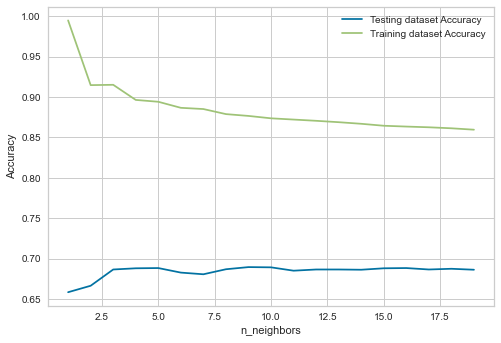

CPU times: user 34.9 s, sys: 656 ms, total: 35.5 s
Wall time: 36.2 s


In [13]:
%%time
###############kNN##############
neighbors = np.arange(1,20)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled_cat, y_train_cat)
     
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train_scaled_cat, y_train_cat)
    test_accuracy[i] = knn.score(X_test_scaled_cat, y_test_cat)
    #print(i,test_accuracy[i])
# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()


In [14]:
%%time
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled_cat, y_train_cat)
print('The results are\n',knn.predict(X_test_scaled_cat))
print('\n')
print('The accuracy is',knn.score(X_test_scaled_cat, y_test_cat))
print('\n')
conf = mt.confusion_matrix(y_test_cat,knn.predict(X_test_scaled_cat),
                           labels = ["high","medium","low"])

print('The confusion matrix is\n', conf)


The results are
 ['low' 'low' 'high' ... 'high' 'medium' 'medium']


The accuracy is 0.6891651865008881


The confusion matrix is
 [[884 181 104]
 [219 682 293]
 [ 70 183 762]]
CPU times: user 837 ms, sys: 19 ms, total: 856 ms
Wall time: 858 ms


In [15]:
from scipy.stats import t

# Let’s now simulate a dataset made of 100 numbers extracted from a normal distribution
x = np.random.normal(size=100)

# calculate the 95% confidence interval of the mean value.
m = x.mean()
s = x.std()

dof = len(x)-1

confidence = 0.95
t_crit = np.abs(t.ppf((1-confidence)/2,dof))

print('The median vlaue is',m) 
print('The standardizaion vlaue is ',s) 

# calculate the 95% confidence interval.
(m-s*t_crit/np.sqrt(len(x)), m+s*t_crit/np.sqrt(len(x)))

The median vlaue is -0.1839174262725544
The standardizaion vlaue is  1.005586045580409


(-0.38344751405667743, 0.015612661511568676)

### *Task 2: Regression of new_deaths*

### Linear Regression

In [16]:
%%time
## Fit the scaled training data to the Linear Regressor and score with R squared

lr_model = LinearRegression().fit(X_train_scaled_reg, y_train_reg)
print('The accuracy of the model is\n',lr_model.score(X_train_scaled_reg, y_train_reg))
print('\n')
## calculate coefficents
print('The linear regression model coefficients are\n',lr_model.coef_)
print('\n')
## calculate intercept
print('The linear regression model intercept is\n',lr_model.intercept_)
print('\n')
##predict new deaths with test values
prediction_lr = lr_model.predict(X_test_scaled_reg)
print('The prediction values are\n',prediction_lr)
print('\n')
## Calculate the RMSE & print      
RMSE_lr = mean_squared_error(prediction_lr, y_test_reg, squared=False)
print('The RMSE is\n',RMSE_lr)

The accuracy of the model is
 0.751806318762606


The linear regression model coefficients are
 [  9.74284487 155.35336676  12.36955594 514.59287848 -52.77958326
  36.82191629 -27.63824879 -11.22443193  10.70582598 -18.55652274
 -14.71380087 -12.60545205  45.0537827 ]


The linear regression model intercept is
 165.28270534222014


The prediction values are
 [ -53.35164346  -57.43586438 4424.33434588 ...  -37.05337059   72.9234811
   50.88897032]


The RMSE is
 469.42196871204214
CPU times: user 27.3 ms, sys: 17.3 ms, total: 44.5 ms
Wall time: 17 ms


### Theil–Sen Regression

In [17]:
%%time
## Fit the scaled training data to the Thiel-Sen Regressor and score with R squared

ts_model = TheilSenRegressor(random_state=0).fit(X_train_scaled_reg, y_train_reg)
print('The Theil–Sen regression model accuracy is',ts_model.score(X_test_scaled_reg, y_test_reg))
print('\n')
      
 ## print the calculated coefficients for the attributes 
print('The Theil–Sen regression model coefficients are',ts_model.coef_)
print('\n')
 ## calculate intercept
print('The Theil–Sen regression model intercept is',ts_model.intercept_)
print('\n')
 ## Predict the new_deaths with the test values
prediction_ts = ts_model.predict(X_test_scaled_reg)

## Calculate the RMSE & print     
  
RMSE_ts = mean_squared_error(prediction_ts, y_test_reg, squared=False)

print('The model RMSE is',RMSE_ts) 

The Theil–Sen regression model accuracy is 0.48813425768982144


The Theil–Sen regression model coefficients are [-1.56630142e+00  3.22007294e+02  4.40213567e+00  3.44679649e+02
 -6.30031145e-01  1.63634590e+00 -1.06597120e+01 -3.10778397e+00
  2.93558518e+00 -1.44848868e-01  6.44236525e+00 -6.85004600e+00
  1.29562143e+01]


The Theil–Sen regression model intercept is 143.0387731005886


The model RMSE is 475.6489230481337
CPU times: user 7.59 s, sys: 1.78 s, total: 9.37 s
Wall time: 9.51 s


### RANSAC Regression

In [18]:
%%time
## Fit the scaled training data to the RANSAC Regressor
rs_model = RANSACRegressor(random_state=0).fit(X_train_scaled_reg, y_train_reg)
print('The accuracy of the RANSAC regression model is',rs_model.score(X_train_scaled_reg, y_train_reg))

 ## Predict the new_deaths with the test values
prediction_rs = rs_model.predict(X_test_scaled_reg)

 ## Calculate the RMSE & print     
  
RMSE_rs = mean_squared_error(prediction_rs, y_test_reg, squared=False)

print('The RMSE of the RANSAC regression model is',RMSE_rs)   

The accuracy of the RANSAC regression model is 0.33494532002782584
The RMSE of the RANSAC regression model is 554.9943487118157
CPU times: user 397 ms, sys: 185 ms, total: 582 ms
Wall time: 234 ms


### Random Forest

In [19]:
%%time
#RandomForestRegression

# Train the model on training data
modelRF = RandomForestRegressor()
modelRF.fit(X_train_scaled_reg, y_train_reg);
prediction_RF = modelRF.predict(X_test_scaled_reg)
#Evaluating the random forest regressor model algorithm using the error metrics
print('Mean Absolute Error:', mt.mean_absolute_error(y_test_reg, prediction_RF))  
print('Mean Squared Error:', mt.mean_squared_error(y_test_reg, prediction_RF))  
print('Root Mean Squared Error:', np.sqrt(mt.mean_squared_error(y_test_reg, prediction_RF)))





Mean Absolute Error: 51.75205840020119
Mean Squared Error: 55392.20955124932
Root Mean Squared Error: 235.35549611438717
CPU times: user 18.9 s, sys: 446 ms, total: 19.4 s
Wall time: 19.7 s


In [20]:
%%time
# create regressor object
RFregressor = RandomForestRegressor(n_estimators = 50)
# fit the regressor with x and y data
RFregressor.fit(X_train_scaled_reg,y_train_reg)
prediction_RF = RFregressor.predict(X_test_scaled_reg)
#Evaluating the random forest regressor model algorithm using the error metrics
print('Mean Absolute Error:', mt.mean_absolute_error(y_test_reg, prediction_RF))  
print('Mean Squared Error:', mt.mean_squared_error(y_test_reg, prediction_RF))  
print('Root Mean Squared Error:', np.sqrt(mt.mean_squared_error(y_test_reg, prediction_RF)))

Mean Absolute Error: 52.166471617296736
Mean Squared Error: 51935.726161985964
Root Mean Squared Error: 227.89411173171186
CPU times: user 9.53 s, sys: 190 ms, total: 9.72 s
Wall time: 9.93 s


 ## Modeling and Evaluation 4

> **Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.**

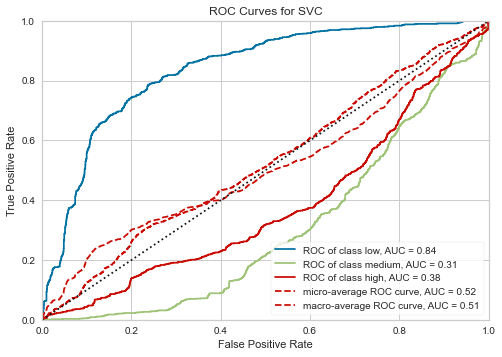

In [21]:
# Yellow Brick visualizer for Prediction Error for SVMs
from yellowbrick.classifier import ROCAUC

rs_visualizer = ROCAUC(svm_clf, classes=["low", "medium", "high"])

rs_visualizer.fit(X_train_scaled_cat, y_train_cat)
rs_visualizer.score(X_test_scaled_cat, y_test_cat)
rs_visualizer.show(); 

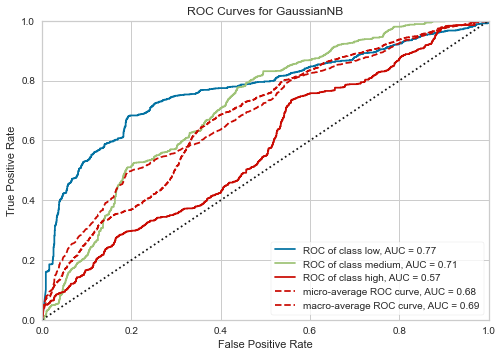

In [22]:
# Yellow Brick visualizer for Prediction Error for Naive Bayes
from yellowbrick.classifier import ROCAUC

rs_visualizer = ROCAUC(gnb_clf, classes=["low", "medium", "high"])

rs_visualizer.fit(X_train_scaled_cat, y_train_cat)
rs_visualizer.score(X_test_scaled_cat, y_test_cat)
rs_visualizer.show(); 

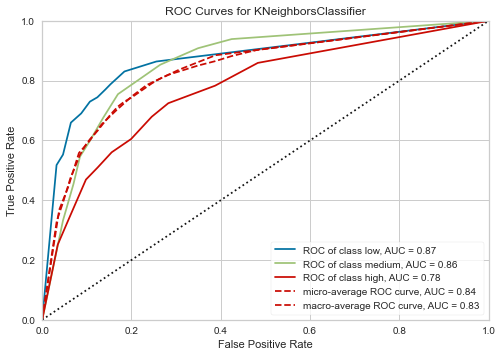

In [23]:
# Yellow Brick visualizer for Prediction Error for kNN
from yellowbrick.classifier import ROCAUC

rs_visualizer = ROCAUC(knn, classes=["low", "medium", "high"])

rs_visualizer.fit(X_train_scaled_cat, y_train_cat)
rs_visualizer.score(X_test_scaled_cat, y_test_cat)
rs_visualizer.show(); 

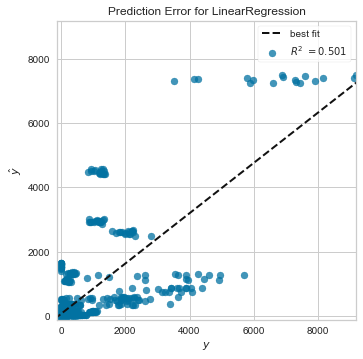

In [24]:
# Yellow Brick visualizer for Prediction Error for Linear Regression

lr_visualizer = PredictionError(lr_model, identity=False)

lr_visualizer.fit(X_train_scaled_reg, y_train_reg)  # Fit the training data to the visualizer
lr_visualizer.score(X_test_scaled_reg, y_test_reg)  # Evaluate the model on the test data
lr_visualizer.show();                 # Finalize and render the figure


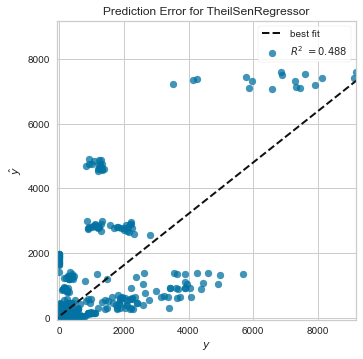

In [25]:
# Yellow Brick visualizer for Prediction Error for Thiel-Sen Regression

ts_visualizer = PredictionError(ts_model, identity=False)

ts_visualizer.fit(X_train_scaled_reg, y_train_reg)  # Fit the training data to the visualizer
ts_visualizer.score(X_test_scaled_reg, y_test_reg)  # Evaluate the model on the test data
ts_visualizer.show();                 # Finalize and render the figure

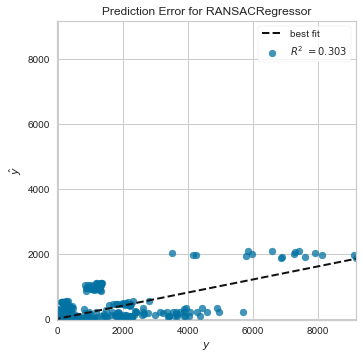

In [26]:
# Yellow Brick visualizer for Prediction Error for RANSAC Regression

rs_visualizer = PredictionError(rs_model, identity=False)

rs_visualizer.fit(X_train_scaled_reg, y_train_reg)  # Fit the training data to the visualizer
rs_visualizer.score(X_test_scaled_reg, y_test_reg)  # Evaluate the model on the test data
rs_visualizer.show();                 # Finalize and render the figure

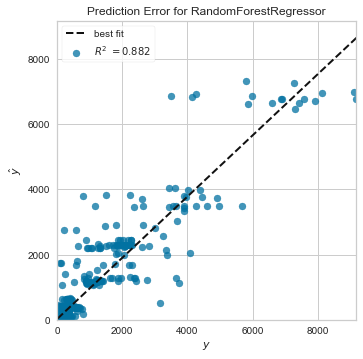

In [27]:
# Yellow Brick visualizer for Prediction Error for Random Forest Regression

rs_visualizer = PredictionError(RFregressor, identity=False)

rs_visualizer.fit(X_train_scaled_reg, y_train_reg)  # Fit the training data to the visualizer
rs_visualizer.score(X_test_scaled_reg, y_test_reg)  # Evaluate the model on the test data
rs_visualizer.show();                 # Finalize and render the figure

Yellow Brick Visualizer for was used for the three graphs above: the Linear, Theil-San, and RANSAC Regression Models. The graphs clearly show that the R2 for the Linear Regression was superior to that of the RANSAC and the Theil-San models. You can also see that there is a linear section that is separate from the main model below the regression line and also several individual areas or "spots" that have some density.

 ## Modeling and Evaluation 5

> **Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.**

| Classification Model                  | Accuracy | Wall Time (ms)                                                                                                                                                                                                                                                                                                                                           |
|--------------------------------|-----------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Support Vector Machines (SVMs)                     | 0.64 | 64000|
| Naive-Bayes                     | 0.45 | 62|
| kNN                     | 0.69 | 936|

| Regression Model                  | RMSE | Wall Time                                                                                                                                                                                                                                                                                                                                           |
|--------------------------------|-----------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Linear Regression                     | 469.42 | 25.7|
| Theil–Sen Regression                     | 475.65 | 11300|
| RANSAC Regression                     | 555.00 | 185|
| Random Forest Regression                    | 227.63 | 11400|


1.	Support Vector Machine (SVM): Advantage of SVM: Outliners have less influence in SVM algorithms, SVM generally do not suffer condition of overfitting and performs well when there is a clear indication of separation between classes. Most of the time SVM gives better accuracy. SVM is also can be robust, even when the training sample has some bias. So its preferable to use SVM in case of classification variables. From our analysis we found that accuracy is 64% And with 95% confidence interval, the expected value for SVM model lies between -0.344 and 0.056.

2.	Naïve- Bayse: The key advantage of Naïve bayse is very simple, easy to implement and fast to predict the class of a test dataset. Its also It is highly scalable with the number of predictors and data points. And its also good to make real time prediction. Form our analysis we found that with the 95% confidence interval the expected value for Naïve bayse model lies between -0.341 And 0.088. 

3.	KNN – the major advantage of KNN over other types of algorithms is it stores the training dataset and learns from it only at the time of making real time predictions, this makes KNN faster than other types of algorithms that requires training. It also has memory bases approach Allows it to immediately adapt to new training data. From our analysis we can see that KNN has produced accuracy of 68%. And with 95% confidence intervals the expected value of the KNN model lies between -0.314 and 0.68.

4. Regression Models - The best performing model of the regression models executed in this report is the Random Forest Regression Model. The major advatage of using regression models is that these can predict an actual value from the data that is fed through the model. The linear regression model was second best, and Theil-Sen and RANSAC Regression models followed. 

Conclusion: There is a famous quote “All models are wrong, but some are useful”. George E. P. Box.  Each model can not describe exact reality, but we believe that our thorough analysis of data can be helpful contributions for prediction. Often, there is a tradeoff between the performance and the model and its execution time. If one wants better performance, longer execution times may be needed.



 ## Modeling and Evaluation 6

> **Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.**

In the mini Lab Project New cases and New deaths and the smoothed versions of these data were very large and highly correlated with each other. We chose to take these data out then and use them for our response variables as they were overwhelming the other attributes.
Once we removed them the most important features based on the weights that were calculated for the variables after scaling were; gdp_per_capita (negative), population (positive), human_development_index (positive) and stringency index (positive), see below.
kNN was the most accurate categorical model with an accuracy of 0.689, Support Vector Machine model was a close second and Naive Bayes model had the lowest accuracy with 0.527. We believe this is because the data is somewhat scattered and has a different morphology depending on the attributes and kNN can take advantage of that.
For our Regressor models, the best representation of the data was the Random Forest model with a RMSE of 229.618. The one attribute with a negative weight, gdp_per_capita, would probably have an effect of being an easier variable to model for the kNN model than the other categorical models. Also, random forest is an algorithm that uses many decisions trees and bagging to build each individual tree. This may have been its' great advantage as the data is very large and sparse in some areas.

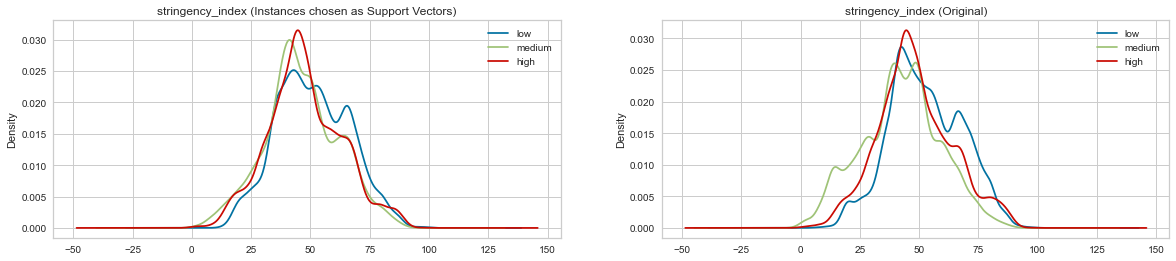

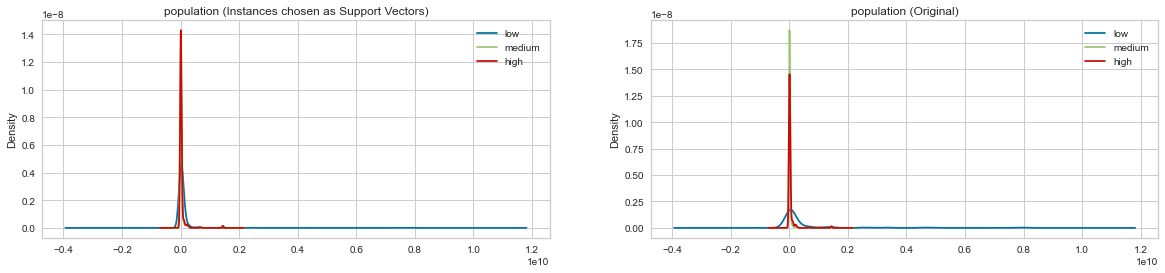

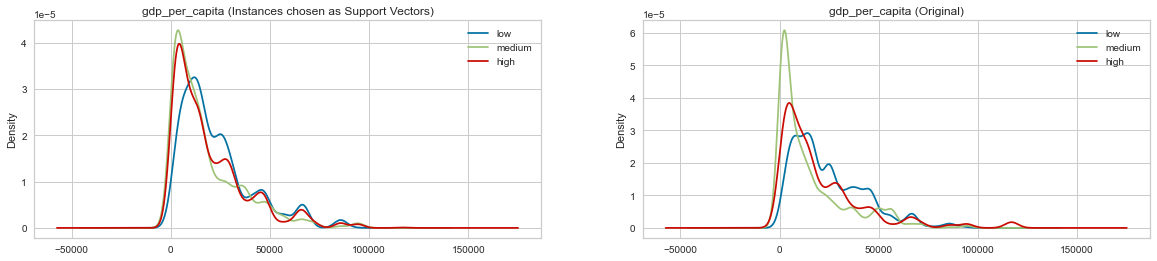

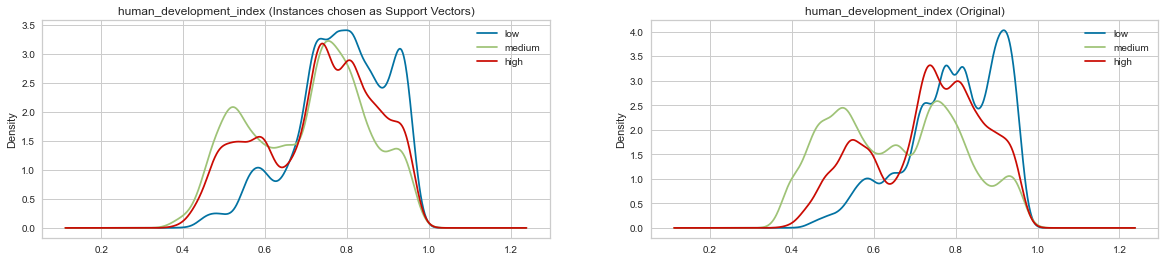

In [28]:
# plot KDE of Different variables
vars_to_plot = ['stringency_index','population','gdp_per_capita','human_development_index']

for v in vars_to_plot:
    plt.figure(figsize=(20,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['low','medium','high'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['low','medium','high'])
    plt.title(v+' (Original)')

 ## Deployment

> **How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)?**


The models created for this analysis use different prediction methods to determine the range of new cases and the number of new deaths resulting from Covid-19. While many of these models may have already been created, there is still a lot unknown about Covid-19. So, companies and organizations are eager to obtain any data and information they can get on Covid-19. If companies have a lot of data, they may want to study different models and outcomes, potentially making our models appealing to different organizations. Companies and organizations such as the CDC, Baylor Scott and White, and other participants in the health industry may be interested in these types of models. They may even improve accuracy of the models by incorporating and adding their own data. 

Also, these models could be very useful for life insurance companies so that they can adjust premiums and underwriting. These insurance companies are significantly impacted by Covid-19: 
"Life insurance policies paid out over $90 billion in 2020, a 15.4% increase over 2019. That’s the largest year-over-year increase since the 1918 influenza pandemic." (source: https://fortune.com/2021/12/09/life-insurance-payouts-2020-record-high-covid/)

> **How would you measure the model's value if it was used by these parties?**

Measuring the models' values across different groups and organizations poses a challenge because what is valuable to one group may not be as valuable to another. Furthermore, how the companies act after interpreting the models' results is the greatest determiner for whether the model is useful to the company or not.
For example, a local public health group has a goal to help predict the range of new cases so that they can warn hospital officials that an increase is in the near feature. Essentially, this group would like to predict the new_case_range for their city based on particular criteria. If the model predicts that the new cases range will be high and they help local hospitals succesfully prepare for an influx of patients, then the model helped the public health group meet their goal. In this scenario, the model would be valuable to them. 

> **How would your deploy your model for interested parties?** 

The dataset used for this analysis was partially obtained from The Covid-19 Data Repository, which is for the Coronavirus Visual Dashboard by the Center for Systems Science and Engineering at Johns Hopkins University, and many other official sources. Since the pandemic's beginning, many people and groups within the health sector have been contributing and building datasets to study Covid-19. Like these groups, our model could also be deployed to GitHub, and we could allow the public to download, execute, and improve our models. To specifically deploy our models to interested parties, we could collaborate with non-profit public health organizations that collaborate with hospitals, primary care facilities, and other health establishments. 

> **What other data should be collected?**

Other data that should be collected may include observations for the variants of Covid-19. Since the viruses continues to mutate, there may be other features that could be implemented in the model. Futhermore, we may discover that some features in the original model are no longer relevant.
Another data category that could be useful for analyzing Covid-19 could be symptoms. Throughout the pandemic, different people have been experiencing many different symptoms and enduring many different outcomes from the virus. By analyzing these symptoms, we may be able to better predict the outcomes of getting infected by Covid-19. 

Exploring granular observations for a particular geographic location, such as the United States could be another area of interest.

Lastly, to better understand the impact of Covid, collecting disability data to understand the magnitude of long Covid.

> **How often would the model need to be updated, etc.?** 

Every day, new data is being created, particularly for Covid-19. As a result, predictive models need to be updated. As we learn more about Covid-19, many new variables may become relevant. While predictive models are capable of handling a lot of new data, too much buildup of new data may cause the models to lose their effectiveness over time. After a month, quarter, or year, updating predictive models with new data is probably necessary. In order to determine how often a model should be updated, one has to consider how often the data is changing and how often decisions are being made off the model. If data is changing very rapidly or decisions are being made often, frequent updates may be best.  When updating the model, you should be sure to investigate the new data, adjust the model, and reevaluate any assumptions made in the creation process. 


 ## Exceptional Work

> **You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?**

We created an extra model, Linear regression (*Modeling and Evaluation 3*), for our Exceptional Work analysis and also used Yellow Brick (*Modeling and Evaluation 4*) for our visualization tasks for our Exceptional Work. By creating a linear regression model, we were able to weight the advantages and disadvantages to the other models. By comparing all regression models, it allowed us to determine which method was better suited for our dataset. Yellow Brick helped our team visualize our predictions from the model and make an educated decision on which models were better.  This was done by examining prediction error, ROC curves, and other factors. Overall, studying a variety of models helped us determine the appropriate model for our dataset.